In [137]:
import pickle
from tqdm import tqdm

import numpy as np
import torch
from torch.optim import Adam
from torch_geometric.utils import get_laplacian, dropout_edge
import matplotlib.pyplot as plt

from dataset import get_dataset
from model import Model as Base

In [41]:
EXP_DIR = 'results/smoothing/2024-06-27-16-41-29'
CKPT = 300
SPLIT = 'val'

with open(f'{EXP_DIR}/config.pkl', 'rb') as f:
    config = pickle.load(f)

DEVICE = torch.device(f'cuda:{config.device_index}' if torch.cuda.is_available() and config.device_index is not None else 'cpu')
dataset = get_dataset(config.dataset, config.task, DEVICE)

In [42]:
class Model(Base):

    def forward(self, x, edge_index, mask):

        for mp_layer in self.message_passing:
            x = mp_layer(x, edge_index)
            yield x

        out = self.readout(x, mask)
        yield out

model = Model(config).to(device=DEVICE)
state_dict = torch.load(f'{EXP_DIR}/ckpt-{CKPT}.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [31]:
model.eval()

with torch.no_grad():
    *representations, logits = model(dataset.x, dataset.edge_index, mask=dataset.test_mask)

dataset.compute_loss(logits, dataset.y[dataset.test_mask])
dataset.compute_metrics()

[('Cross Entropy Loss', 0.5278717041015625),
 ('Accuracy', 0.8379963040351868),
 ('F1 Score', 0.8460693359375),
 ('AU-ROC', 0.9691168665885925)]

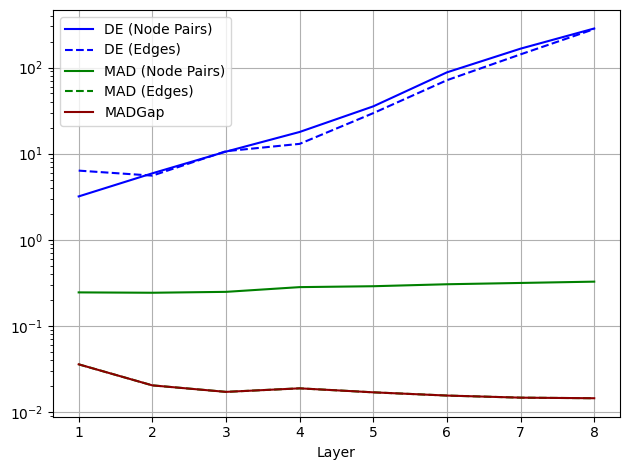

In [19]:
dir_energies_all, dir_energies_edges, mad_vals_all, mad_vals_edges, mad_gaps = list(), list(), list(), list(), list()

for representation in representations:

    pairwise_euclidean_sq = torch.square(torch.cdist(representation, representation))
    dir_energy_all = torch.mean(pairwise_euclidean_sq).item()
    dir_energies_all.append(dir_energy_all)
    dir_energy_edges = torch.mean(pairwise_euclidean_sq[dataset.edge_index[0], dataset.edge_index[1]]).item(); 
    dir_energies_edges.append(dir_energy_edges)
    
    pairwise_cossim = torch.nn.CosineSimilarity(dim=-1, eps=1e-20)(representation.unsqueeze(0), representation.unsqueeze(1))
    mad_val_all = 1 - torch.mean(pairwise_cossim).item()
    mad_vals_all.append(mad_val_all)
    mad_val_edges = 1 - torch.mean(pairwise_cossim[dataset.edge_index[0], dataset.edge_index[1]]).item()
    mad_vals_edges.append(mad_val_edges)
    mask_nbr = torch.zeros_like(pairwise_cossim)
    mask_nbr[dataset.edge_index[0], dataset.edge_index[1]] = 1.
    mad_nbr = 1 - torch.mean(torch.sum(pairwise_cossim*mask_nbr, dim=1) / torch.sum(mask_nbr, dim=1)).item()
    mask_rmt = torch.ones_like(pairwise_cossim)
    mask_rmt[dataset.edge_index[0], dataset.edge_index[1]] = 0.
    mad_rmt = 1 - torch.mean(torch.sum(pairwise_cossim*mask_rmt, dim=1) / torch.sum(mask_rmt, dim=1)).item()
    mad_gaps.append(mad_rmt-mad_nbr)

plt.plot(range(1, len(dir_energies_all)+1), dir_energies_all, 'b-', label='DE (Node Pairs)')
plt.plot(range(1, len(dir_energies_edges)+1), dir_energies_edges, 'b--', label='DE (Edges)')
plt.plot(range(1, len(mad_vals_all)+1), mad_vals_all, 'g-', label='MAD (Node Pairs)')
plt.plot(range(1, len(mad_vals_edges)+1), mad_vals_edges, 'g--', label='MAD (Edges)')
plt.plot(range(1, len(mad_vals_edges)+1), mad_vals_edges, 'darkred', label='MADGap')
plt.xlabel('Layer')
plt.yscale('log')
plt.legend()
plt.grid(which='major')
plt.tight_layout()
plt.show()

# cross-checked with the results using the official implementation
# https://github.com/victorchen96/MadGap/blob/4e49f254bde40b181e749a51dbc7a3abc3153d4c/madgap.py#L13

In [43]:
class Model(Base):

    def forward(self, x, edge_index, mask):

        for mp_layer in self.message_passing[:self.stop]:
            x = mp_layer(x, edge_index)

        out = self.readout(x, mask)
        return out

model = Model(config).to(device=DEVICE)
state_dict = torch.load(f'{EXP_DIR}/ckpt-{CKPT}.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [45]:
N_EPOCHS = 100
results = list()

for mp_steps in range(1, len(representations)+1):

    model.stop = i
    for ffn_layer in model.readout.ffn.children():
        ffn_layer.reset_parameters()
    optimizer = Adam(model.readout.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    results.append({'Val Metrics': list(), 'Test Metrics': list()})
    dataset.reset_metrics()
    for epoch in tqdm(range(N_EPOCHS)):
        train_metrics = dataset.train(model, optimizer)
        val_metrics, test_metrics = dataset.eval(model)
        results[-1]['Val Metrics'].append(val_metrics)
        results[-1]['Test Metrics'].append(test_metrics)

100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


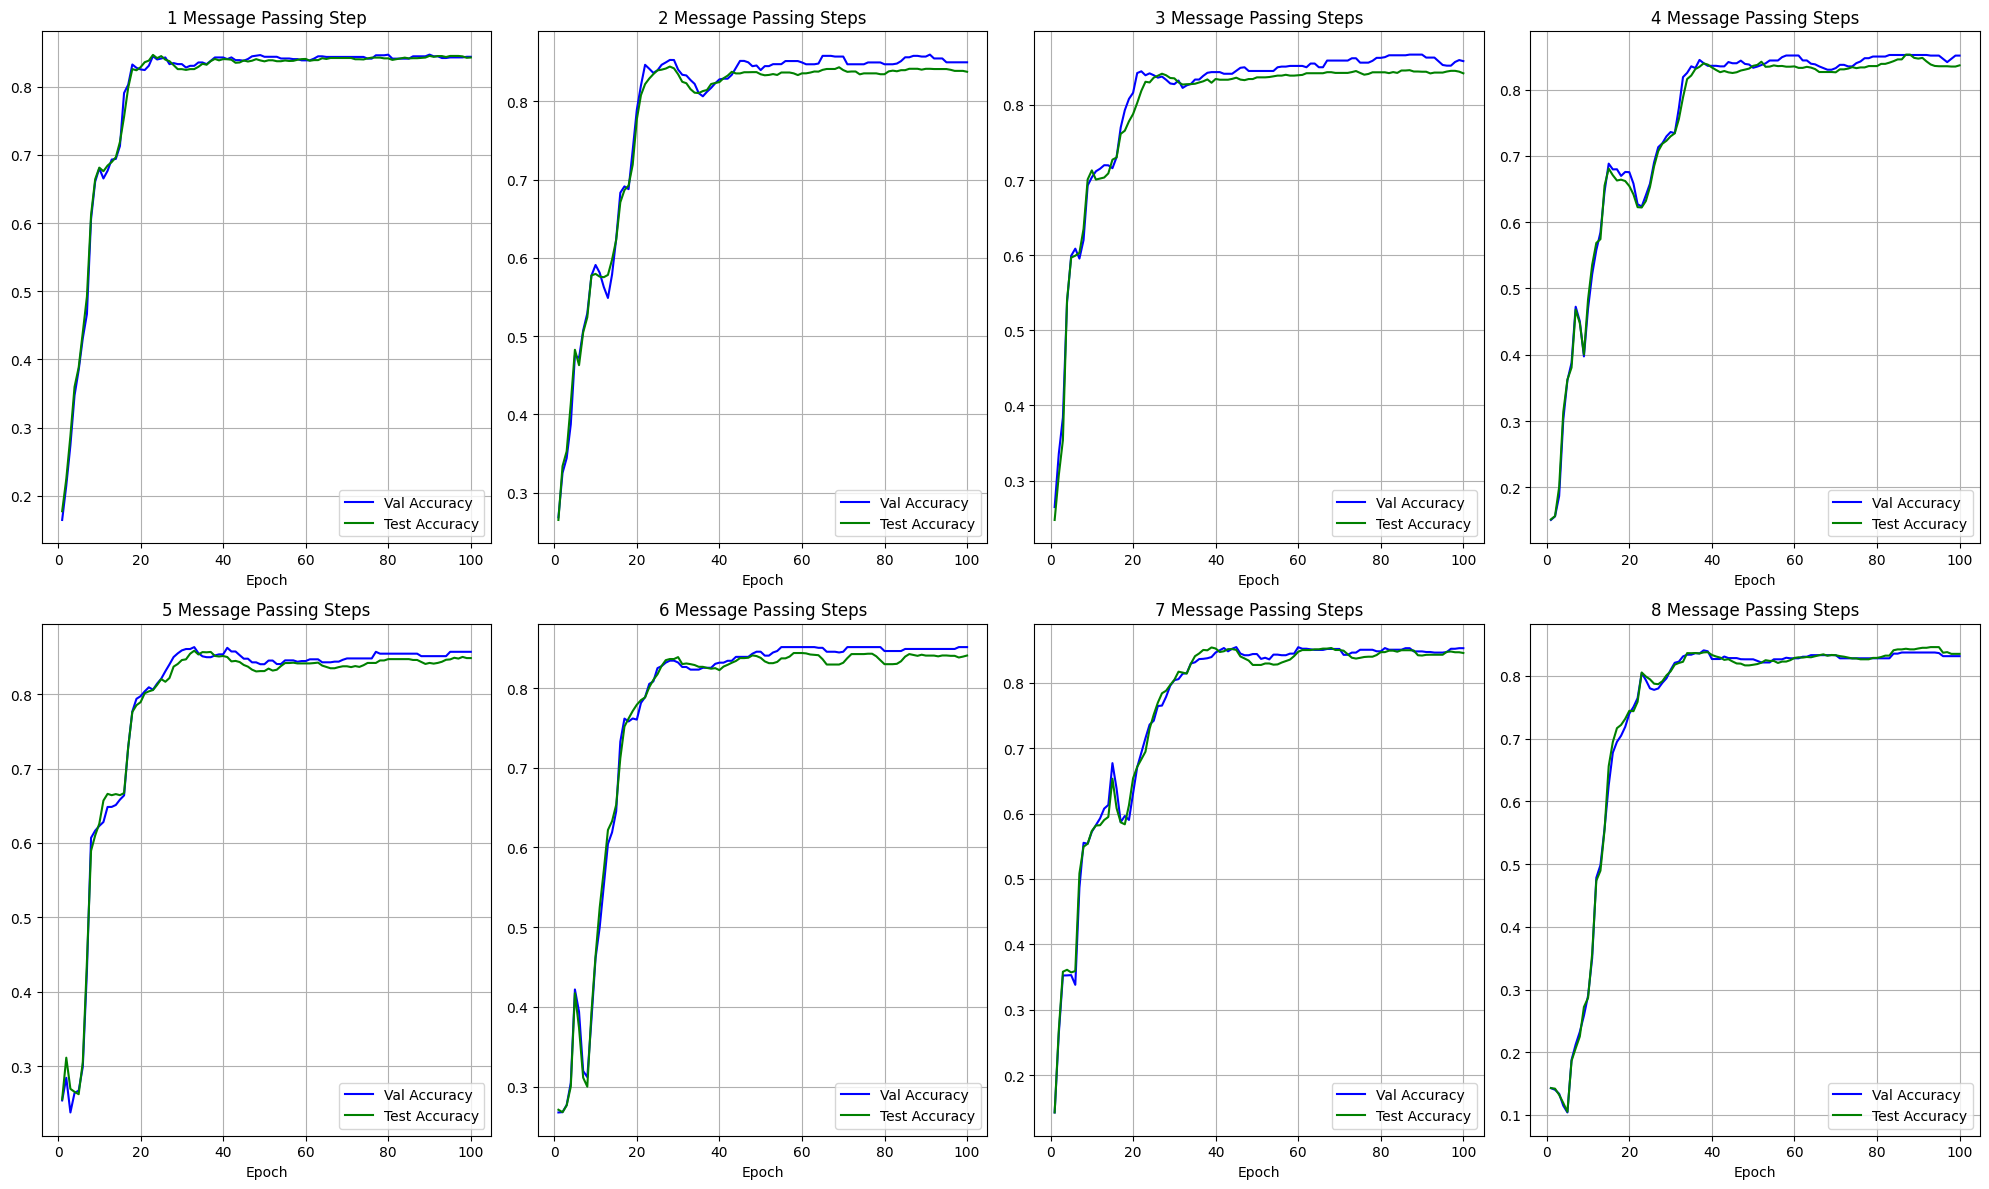

In [77]:
metric = 'Accuracy'
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for i in range(8):
    result = results[i]
    ax = axs[i//4, i%4]
    for (split, metrics), color in zip(result.items(), ('blue', 'green')):
        y = [val for x in metrics for name, val in x if name == metric]
        ax.plot(range(1, len(y)+1), y, color=color, label=split.replace('Metrics', metric))
    ax.set_xlabel('Epoch')
    ax.set_title(f'{i+1} Message Passing Step' + ('s' if i != 0 else ''))
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.show()

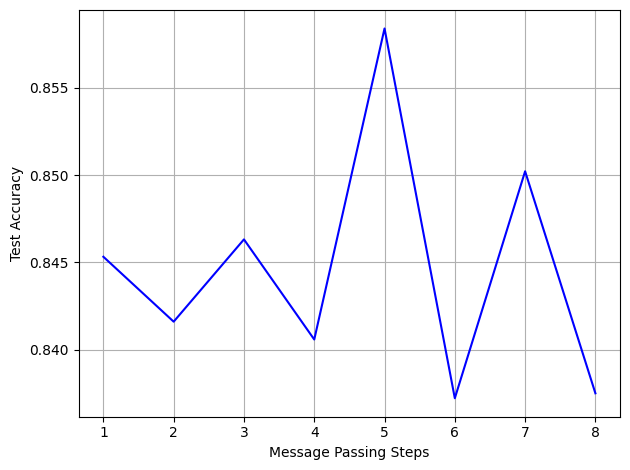

In [78]:
metric = 'Accuracy'
es_test_metrics = list()

for i in range(8):
    result = results[i]
    val_metrics = [dict(metrics)[metric] for metrics in result['Val Metrics']]
    best_epoch = np.argmax(val_metrics)
    test_metrics = [dict(metrics)[metric] for metrics in result['Test Metrics']]
    es_test_metrics.append(test_metrics[best_epoch])

plt.plot(range(1, 9), es_test_metrics, color='blue')
plt.xlabel('Message Passing Steps')
plt.ylabel(f'Test {metric}')
plt.grid()
plt.tight_layout()
plt.show()

In [79]:
N_EPOCHS = 100
N_SAMPLES = 10
metric = 'Accuracy'
es_test_metrics = list()

for mp_steps in range(1, len(representations)+1):

    model.stop = i
    es_test_metrics.append(list())

    for sample in tqdm(range(N_SAMPLES)):

        for ffn_layer in model.readout.ffn.children():
            ffn_layer.reset_parameters()
        optimizer = Adam(model.readout.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        best_val_metric, es_test_metric = 0., 0.
        dataset.reset_metrics()
        for epoch in range(N_EPOCHS):
            train_metrics = dataset.train(model, optimizer)
            val_metrics, test_metrics = dataset.eval(model)
            if dict(val_metrics)[metric] > best_val_metric:
                es_test_metric = dict(test_metrics)[metric]
        
        es_test_metrics[-1].append(es_test_metric)

100%|██████████| 10/10 [02:23<00:00, 14.33s/it]


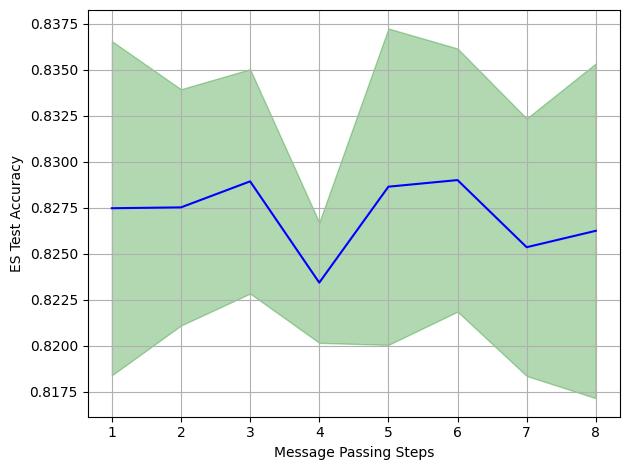

In [86]:
lower, means, upper = list(), list(), list()

for i in range(8):
    result = es_test_metrics[i]
    mean, std = np.mean(result), np.std(result)
    lower.append(mean-std)
    means.append(mean)
    upper.append(mean+std)

plt.plot(range(1, 9), means, color='blue')
plt.fill_between(range(1, 9), lower, upper, alpha=0.3, color='green')
plt.xlabel('Message Passing Steps')
plt.ylabel(f'ES Test {metric}')
plt.grid()
plt.tight_layout()
plt.show()

In [142]:
N_SAMPLES = 10
results = dict()

for p in tqdm(np.linspace(0.1, 0.9, 9)):

    results[p] = list()

    for _ in range(N_SAMPLES):
        
        dropped_adj = dropout_edge(dataset.edge_index)[0]
    
        laplacian_edge_index, laplacian_edge_weights = get_laplacian(dropped_adj)
        laplacian = torch.zeros((dataset.y.size(0), dataset.y.size(0)))
        laplacian[laplacian_edge_index[0], laplacian_edge_index[1]] = laplacian_edge_weights

        laplacian_pinv = torch.linalg.pinv(laplacian)
        laplacian_pinv_diag = torch.diag(laplacian_pinv)
        commute_times = dropped_adj.size(1) * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - 2*laplacian_pinv)

        avg_commute_time = 2 * torch.sum(torch.triu(commute_times, diagonal=1)) / (commute_times.size(0)*(commute_times.size(0)-1))
        results[p].append(avg_commute_time)

In [ ]:
laplacian_edge_index, laplacian_edge_weights = get_laplacian(dataset.edge_index)
laplacian = torch.zeros((dataset.y.size(0), dataset.y.size(0)))
laplacian[laplacian_edge_index[0], laplacian_edge_index[1]] = laplacian_edge_weights

laplacian_pinv = torch.linalg.pinv(laplacian)
laplacian_pinv_diag = torch.diag(laplacian_pinv)
commute_times = dataset.edge_index.size(1) * (laplacian_pinv_diag.unsqueeze(0) + laplacian_pinv_diag.unsqueeze(1) - 2*laplacian_pinv)

no_drop_avg_commute_time = 2 * torch.sum(torch.triu(commute_times, diagonal=1)) / (commute_times.size(0)*(commute_times.size(0)-1))

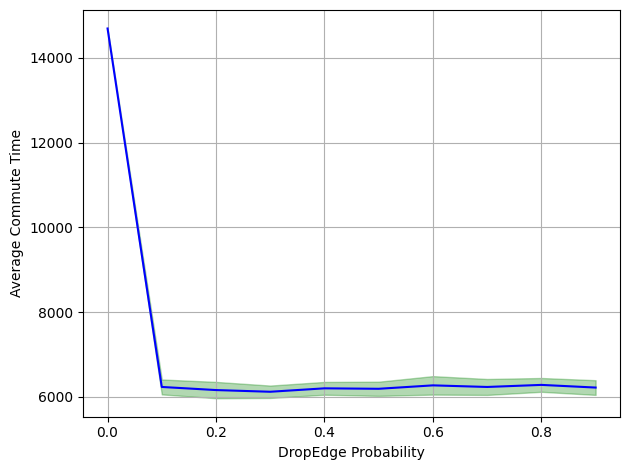

In [144]:
x, lower, means, upper = [0.0], [no_drop_avg_commute_time], [no_drop_avg_commute_time], [no_drop_avg_commute_time]

for p, avg_commute_times in results.items():
    mean, std = np.mean(avg_commute_times), np.std(avg_commute_times)
    x.append(p)
    lower.append(mean-std)
    means.append(mean)
    upper.append(mean+std)

plt.plot(x, means, color='blue')
plt.fill_between(x, lower, upper, alpha=0.3, color='green')
plt.xlabel('DropEdge Probability')
plt.ylabel(f'Average Commute Time')
plt.grid()
plt.tight_layout()
plt.show()

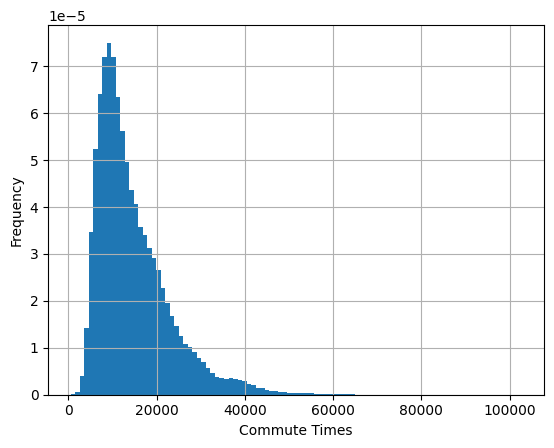

In [147]:
commute_times_flattened = torch.triu(commute_times, diagonal=1).flatten()
commute_times_filtered = commute_times_flattened[commute_times_flattened > 0.]

plt.hist(commute_times_filtered, bins=100, density=True)
plt.xlabel('Commute Times')
plt.ylabel('Frequency')
plt.grid()
plt.show()